## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
from datasets import load_from_disk
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score
from collections import Counter, defaultdict
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification 
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from datasets import load_metric, concatenate_datasets, load_from_disk
from collections import Counter, defaultdict
import seaborn as sns
from matplotlib import pyplot as plt

/home/eli/envs/bt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

In [2]:
model_name = 'deepset/gbert-base'

In [3]:
date_of_experiment = '2022_07_10'

## Tokenizer

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name) # more params defined in method tokenize_and_align_labels()

## Data collator

In [5]:
data_collator = DataCollatorForTokenClassification(tokenizer)

## Training params

In [6]:
NUM_EPOCHS = 10
BATCH_SIZE = 4
LOGGING_STRATEGY='epoch'
OUTPUT_DIR = f'../../../../../models/{model_name}-sm_tg_combined-{NUM_EPOCHS}_epochs_{date_of_experiment}'
OVERWRITE_OUTPUT_DIR = True
LOG_LEVEL = 'error'
EVALUATION_STRATEGY = 'epoch'
SAVE_STRATEGY ='epoch'
WEIGHT_DECAY = 0.01 # The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.
CALLBACK = EarlyStoppingCallback(early_stopping_patience=3)
LOAD_BEST_MODEL_AT_END = True,
METRIC_FOR_BEST_MODEL='eval_loss'

## Check GPU and set up torch device

In [7]:
# check gpu
torch.cuda.is_available()

True

In [8]:
# create torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and prepare data

### Combine Smartdata and Telegram train splits to create training data

In [9]:
smartdata = load_from_disk('/home/eli/data/data_prepared_for_tf/smartdata/')
telegram = load_from_disk('/home/eli/data/data_prepared_for_tf/telegram_train_test_valid/')
assert smartdata['train'].features == telegram['train'].features
assert smartdata['test'].features == telegram['test'].features
assert smartdata['validation'].features == telegram['validation'].features

In [10]:
assert smartdata['validation'].features == telegram['validation'].features

In [11]:
telegram['validation'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=13, names=['O', 'B-DATE', 'I-DATE', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-TIME', 'I-TIME', 'B-ACTION', 'I-ACTION'], id=None), length=-1, id=None),
 'ner_tags_str': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [12]:
train_ds = concatenate_datasets([smartdata['train'], telegram['train']])

### Shuffle training data

In [13]:
train_ds = train_ds.shuffle(seed=42)

Loading cached shuffled indices for dataset at /home/eli/data/data_prepared_for_tf/smartdata/train/cache-f2fd20590db54290.arrow


### Combine Smartdata and Telegram test splits as validation set

In [14]:
telegram['validation'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=13, names=['O', 'B-DATE', 'I-DATE', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-TIME', 'I-TIME', 'B-ACTION', 'I-ACTION'], id=None), length=-1, id=None),
 'ner_tags_str': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [15]:
smartdata['validation'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=13, names=['O', 'B-DATE', 'I-DATE', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-TIME', 'I-TIME', 'B-ACTION', 'I-ACTION'], id=None), length=-1, id=None),
 'ner_tags_str': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [16]:
eval_ds = concatenate_datasets([smartdata['validation'], telegram['validation']])

### Methods for processing

In [17]:
def get_indices_and_tags(ds, tag_name='ner_tags'):
    tags = ds.features[tag_name].feature
    #id2label param for model
    index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
    # label2id param for model
    tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
    
    return tags, index2tag, tag2index


def tokenize_and_align_labels(examples):
    
    tokenized_inputs = tokenizer(
        examples['tokens'], 
        padding='max_length',
        truncation=True, 
        is_split_into_words=True
    )    
    
    labels = []
    
    for idx, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else: 
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs


def encode_dataset(corpus, columns_to_remove=['ner_tags', 'tokens', 'ner_tags_str']):
    return corpus.map(tokenize_and_align_labels, 
                      batched=True,
                      remove_columns=columns_to_remove,
                      load_from_cache_file=False)

### Methods for evaluation

In [18]:
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        labels_list.append(example_labels)
        preds_list.append(example_preds)
        
    return preds_list, labels_list    


def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    return {'f1': f1, 
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy}


def get_training_history(trainer):
    df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_accuracy']]
    df = df.rename(columns={"epoch":"epoch",
                            "loss": "training_loss", 
                            "eval_loss": "validation_loss", 
                            "eval_f1":"f1", 
                            "eval_precision": "precision",
                           'eval_recall': 'recall', 
                            'eval_accuracy': 'accuracy'})
    df['epoch'] = df["epoch"].apply(lambda x: round(x))
    df['training_loss'] = df["training_loss"].ffill()
    df[['validation_loss', 'f1']] = df[['validation_loss', 'f1']].bfill().ffill()
    df.drop_duplicates()
    
    return df

In [19]:
tags, index2tag, tag2index = get_indices_and_tags(train_ds)

In [20]:
train_encoded = encode_dataset(train_ds)

Parameter 'function'=<function tokenize_and_align_labels at 0x7fe6be2eb790> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.74ba/s]


In [21]:
eval_encoded = encode_dataset(eval_ds)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.35ba/s]


In [22]:
df = train_encoded.to_pandas()

In [23]:
df[['input_ids', 'labels']].head()

input_ids  \
0  [102, 20739, 8497, 30914, 10412, 30925, 22171,...   
1  [102, 17329, 14705, 18315, 17329, 19281, 30904...   
2  [102, 718, 1412, 6556, 17077, 3859, 136, 8139,...   
3  [102, 493, 566, 1483, 1073, 818, 3035, 853, 32...   
4  [102, 15591, 17329, 7938, 2032, 305, 1055, 853...   

                                              labels  
0  [-100, 0, -100, -100, -100, -100, -100, -100, ...  
1  [-100, 0, -100, -100, 5, -100, -100, -100, -10...  
2  [-100, 0, 3, -100, -100, -100, 0, 3, -100, 0, ...  
3  [-100, 1, 2, 2, 2, 0, 9, -100, -100, 10, 5, 0,...  
4  [-100, 0, 0, -100, -100, -100, -100, 0, 0, 0, ...

In [26]:
print(train_encoded.features)

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [27]:
df.head()

input_ids  \
0  [102, 20739, 8497, 30914, 10412, 30925, 22171,...   
1  [102, 17329, 14705, 18315, 17329, 19281, 30904...   
2  [102, 718, 1412, 6556, 17077, 3859, 136, 8139,...   
3  [102, 493, 566, 1483, 1073, 818, 3035, 853, 32...   
4  [102, 15591, 17329, 7938, 2032, 305, 1055, 853...   

                                      token_type_ids  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                              labels  
0  [-100, 0, -100, -100, -100, -100, -100, -100, ...  
1  [-100, 0, -100, -100, 5, -100, -100, -100, -10...  
2  [-100, 0, 3, -100, -100, -100, 0, 3, -100, 0, ...  
3  [-100, 1, 2, 2, 2, 0, 9, -100, -100, 10, 5, 0,...  
4  [-100, 0, 0, -100, -100, -100, -100, 0, 0, 0, ...

## model initialization and config

In [22]:
model_config = AutoConfig.from_pretrained(model_name, 
                                        num_labels=tags.num_classes, 
                                        id2label=index2tag,
                                        label2id=tag2index)

In [23]:
model = AutoModelForTokenClassification.from_pretrained(model_name, config=model_config).to(device)

Some weights of the model checkpoint at deepset/gbert-base were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at deepset/gb

## Training

In [24]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR, 
    overwrite_output_dir=OVERWRITE_OUTPUT_DIR, 
    log_level=LOG_LEVEL, 
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE, 
    evaluation_strategy=EVALUATION_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    weight_decay=WEIGHT_DECAY,
    logging_strategy=LOGGING_STRATEGY,
    disable_tqdm=False,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    metric_for_best_model=METRIC_FOR_BEST_MODEL)

In [25]:
trainer = Trainer(
    model=model, 
    args=training_args,
    data_collator=data_collator, 
    compute_metrics=compute_metrics,
    train_dataset=train_encoded,
    eval_dataset=eval_encoded,
    tokenizer=tokenizer,
    callbacks=[CALLBACK])

In [26]:
%time
trainer.train()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


/home/eli/envs/bt/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=2264, training_loss=0.10760116914135828, metrics={'train_runtime': 563.7277, 'train_samples_per_second': 40.108, 'train_steps_per_second': 10.04, 'total_flos': 2363402885738496.0, 'train_loss': 0.10760116914135828, 'epoch': 4.0})

In [27]:
trainer.evaluate()

{'eval_loss': 0.17507117986679077,
 'eval_f1': 0.79221140472879,
 'eval_precision': 0.7815587266739846,
 'eval_recall': 0.8031584884376762,
 'eval_accuracy': 0.9515880159444516,
 'eval_runtime': 5.7788,
 'eval_samples_per_second': 48.106,
 'eval_steps_per_second': 12.113,
 'epoch': 4.0}

In [28]:
eval_df = get_training_history(trainer)

In [29]:
eval_df

epoch  training_loss  validation_loss        f1  precision    recall  \
0      1         0.2138         0.175071  0.792211        NaN       NaN   
1      1         0.2138         0.175071  0.792211   0.781559  0.803158   
2      2         0.1022         0.178425  0.810796        NaN       NaN   
3      2         0.1022         0.178425  0.810796   0.792250  0.830231   
4      3         0.0680         0.182290  0.813908        NaN       NaN   
5      3         0.0680         0.182290  0.813908   0.802964  0.825155   
6      4         0.0464         0.223667  0.815529        NaN       NaN   
7      4         0.0464         0.223667  0.815529   0.796665  0.835307   
8      4         0.0464         0.175071  0.792211        NaN       NaN   
9      4         0.0464         0.175071  0.792211   0.781559  0.803158   

   accuracy  
0       NaN  
1  0.951588  
2       NaN  
3  0.955060  
4       NaN  
5  0.954610  
6       NaN  
7  0.955124  
8       NaN  
9  0.951588

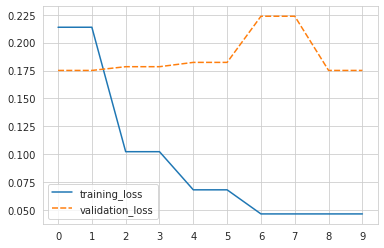

In [33]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = eval_df[['training_loss', 'validation_loss']])
ax.set_xticks(range(len(eval_df)), labels=range(len(eval_df)))
plt.show()

In [36]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = eval_df[['f1', 'precision', 'recall', 'accuracy']])
ax.set_xticks(range(len(eval_df)), labels=range(len(eval_df)))
plt.show()

In [35]:
trainer.create_model_card()

In [44]:
df.head()

input_ids  \
0  [102, 12052, 30886, 6357, 853, 201, 1270, 2530...   
1  [102, 5901, 683, 3086, 422, 30901, 232, 29794,...   
2  [102, 178, 7369, 232, 23981, 30886, 478, 4097,...   
3  [102, 1799, 3512, 4001, 23847, 370, 218, 22646...   
4  [102, 11085, 4245, 1582, 212, 16170, 26311, 54...   

                                      token_type_ids  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                              labels  \
0  [-100, 0, -100, 0, 0, 0, 3, 0, 0, -100, 0, 0, ...   
1  [-100, 0, 0, 0, -100, -100, 0, 0, 0, 0, 0, 0, ...   
2  [-100, 0, -100, 0, 0, -100, 0, 0, 3, 0, 0, 0, ...   
3  [-100, 0, -100, -100, -100, -100, 5, -100, 0, ...   
4  [-100, 5, -100, 0, 0, 0, -100, 0, 0, 0, -100, ...   

                                                loss  \
0  [0.0, 0.004093364, 0.0, 0.0015407845, 0.001775...   
1  [0.0, 0.0004290614, 0.0005821679, 0.01709582, ...   
2  [0.0, 0.008612394, 0.0, 0.009297172, 0.0104482...   
3  [0.0, 0.16625221, 0.0, 0.0, 0.0, 0.0, 0.030124...   
4  [0.0, 0.04774178, 0.0, 0.0035494678, 0.0005953...   

                                     predicted_label  
0  [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 2, 2, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 5, 0, 0, ...  
4  [0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, ...